In [1]:
!pip install BeautifulSoup4
!pip install --upgrade scikit-learn -q

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/word2vec-nlp-tutorial/testData.tsv.zip
/kaggle/input/word2vec-nlp-tutorial/sampleSubmission.csv
/kaggle/input/word2vec-nlp-tutorial/unlabeledTrainData.tsv.zip
/kaggle/input/word2vec-nlp-tutorial/labeledTrainData.tsv.zip


In [3]:
import nltk
import numpy as np 
import optuna
import pandas as pd
import re
import subprocess
import warnings

from bs4 import BeautifulSoup  

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

# Now import the NLTK resources as usual
from nltk.corpus import wordnet

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


from tqdm import tqdm

warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /kaggle/working/corpora/wordnet.zip


replace /kaggle/working/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


In [4]:
train = pd.read_csv('/kaggle/input/word2vec-nlp-tutorial/labeledTrainData.tsv.zip', header=0, delimiter="\t", quoting=3)
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [5]:
train.shape

(25000, 3)

In [6]:
train.columns.values

array(['id', 'sentiment', 'review'], dtype=object)

In [7]:
train["review"][0]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally

In [8]:
test = pd.read_csv('/kaggle/input/word2vec-nlp-tutorial/testData.tsv.zip', header=0, delimiter="\t", quoting=3)
test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [9]:
test.shape

(25000, 2)

In [10]:
test.columns.values

array(['id', 'review'], dtype=object)

In [11]:
test["review"][0]

'"Naturally in a film who\'s main themes are of mortality, nostalgia, and loss of innocence it is perhaps not surprising that it is rated more highly by older viewers than younger ones. However there is a craftsmanship and completeness to the film which anyone can enjoy. The pace is steady and constant, the characters full and engaging, the relationships and interactions natural showing that you do not need floods of tears to show emotion, screams to show fear, shouting to show dispute or violence to show anger. Naturally Joyce\'s short story lends the film a ready made structure as perfect as a polished diamond, but the small changes Huston makes such as the inclusion of the poem fit in neatly. It is truly a masterpiece of tact, subtlety and overwhelming beauty."'

In [12]:
unlabeled_train  = pd.read_csv('/kaggle/input/word2vec-nlp-tutorial/unlabeledTrainData.tsv.zip', header=0, delimiter="\t", quoting=3)
unlabeled_train.head()

,id,review
0,"""9999_0""","""Watching Time Chasers, it obvious that it was..."
1,"""45057_0""","""I saw this film about 20 years ago and rememb..."
2,"""15561_0""","""Minor Spoilers<br /><br />In New York, Joan B..."
3,"""7161_0""","""I went to see this film with a great deal of ..."
4,"""43971_0""","""Yes, I agree with everyone on this site this ..."


In [13]:
unlabeled_train.shape

(50000, 2)

In [14]:
unlabeled_train.columns.values

array(['id', 'review'], dtype=object)

In [15]:
sample_submission  = pd.read_csv('/kaggle/input/word2vec-nlp-tutorial/sampleSubmission.csv', header=0, delimiter="\t", quoting=3)
sample_submission.head()

,"""id"",""sentiment"""
0,"""12311_10"",0"
1,"""8348_2"",0"
2,"""5828_4"",0"
3,"""7186_2"",0"
4,"""12128_7"",0"


In [16]:
sample_submission.shape

(25000, 1)

In [17]:
sample_submission.columns.values

array(['"id","sentiment"'], dtype=object)

In [18]:
# check for missing values in train data
train.isna().sum()

id           0
sentiment    0
review       0
dtype: int64

In [19]:
# check for missing values in test data
test.isna().sum()

id        0
review    0
dtype: int64

In [20]:
# check for duplicates in train data
train.duplicated().sum()

0

In [21]:
# check for duplicates in test data
test.duplicated().sum()

0

**Data Cleaning and Text Preprocessing**

In [22]:
def text_preprocessing(raw_review):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review).get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))   

In [23]:
tqdm.pandas()
clean_train_reviews = train["review"].progress_apply(text_preprocessing) 
clean_train_reviews[0]

100%|██████████| 25000/25000 [00:21<00:00, 1145.21it/s]


'stuff going moment mj started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighties maybe make mind whether guilty innocent moonwalker part biography part feature film remember going see cinema originally released subtle messages mj feeling towards press also obvious message drugs bad kay visually impressive course michael jackson unless remotely like mj anyway going hate find boring may call mj egotist consenting making movie mj fans would say made fans true really nice actual feature film bit finally starts minutes excluding smooth criminal sequence joe pesci convincing psychopathic powerful drug lord wants mj dead bad beyond mj overheard plans nah joe pesci character ranted wanted people know supplying drugs etc dunno maybe hates mj music lots cool things like mj turning car robot whole speed demon sequence also director must patience saint came filming kiddy bad sequence usually directors hate workin

In [24]:
tqdm.pandas()
clean_test_reviews = test["review"].progress_apply(text_preprocessing) 
clean_test_reviews[0]

100%|██████████| 25000/25000 [00:21<00:00, 1148.78it/s]


'naturally film main themes mortality nostalgia loss innocence perhaps surprising rated highly older viewers younger ones however craftsmanship completeness film anyone enjoy pace steady constant characters full engaging relationships interactions natural showing need floods tears show emotion screams show fear shouting show dispute violence show anger naturally joyce short story lends film ready made structure perfect polished diamond small changes huston makes inclusion poem fit neatly truly masterpiece tact subtlety overwhelming beauty'

sentiment
1    0.5
0    0.5
Name: proportion, dtype: float64


<Axes: xlabel='sentiment'>

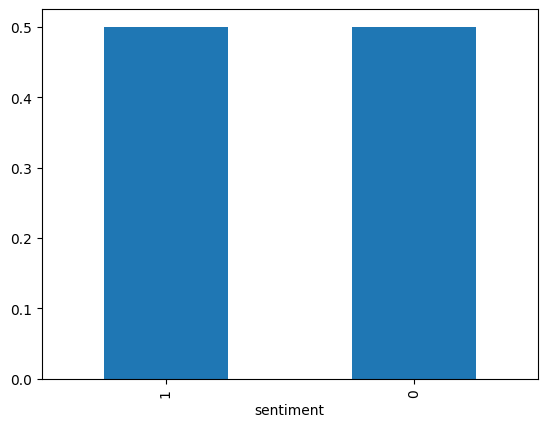

In [25]:
# class balance study
class_frequency = train["sentiment"].value_counts(normalize = 1)
print(class_frequency)
class_frequency.plot(kind='bar')

The classes are evenly distributed.

**Creating Features using TfidfVectorizer**

In [26]:
vectorizer = TfidfVectorizer(max_features = 5000) 

train_data_features  = vectorizer.fit_transform(clean_train_reviews)
train_data_features.shape

(25000, 5000)

In [27]:
test_data_features = vectorizer.transform(clean_test_reviews)
test_data_features.shape

(25000, 5000)

In [28]:
# split data into train and validation sets
X = train_data_features
y = train["sentiment"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=12345)

**Logistic Regression**

In [29]:
def objective(trial):
    C = trial.suggest_float('C', 1e-5, 1e5, log=True)  
    solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])

    model = LogisticRegression(C=C, solver=solver, random_state=12345)
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, y_pred_prob)
    return roc_auc

In [30]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
best_params = study.best_params
best_c = best_params['C']
best_solver = best_params['solver']

best_model_lr = LogisticRegression(C=best_c, solver=best_solver, max_iter=1000)
best_model_lr.fit(X, y)
best_score = study.best_value 
best_score

[I 2024-07-17 18:47:50,866] A new study created in memory with name: no-name-69c967aa-0ecb-40ea-b77b-f4dfd6059a55
[I 2024-07-17 18:47:51,161] Trial 0 finished with value: 0.9513139897553666 and parameters: {'C': 0.33657570423520683, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.9513139897553666.
[I 2024-07-17 18:47:51,721] Trial 1 finished with value: 0.9401595259536899 and parameters: {'C': 0.08186828980832361, 'solver': 'sag'}. Best is trial 0 with value: 0.9513139897553666.
[I 2024-07-17 18:47:56,216] Trial 2 finished with value: 0.946403689501715 and parameters: {'C': 24.643072871635894, 'solver': 'saga'}. Best is trial 0 with value: 0.9513139897553666.
[I 2024-07-17 18:47:56,444] Trial 3 finished with value: 0.906947354003094 and parameters: {'C': 0.0005392811694261744, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.9513139897553666.
[I 2024-07-17 18:48:01,111] Trial 4 finished with value: 0.9205975310728063 and parameters: {'C': 50960.7452463913, 'solver': 'sag'}. Best

0.9568308969846626

**Creating a Submission**

In [31]:
prediction = best_model_lr.predict(test_data_features)
prediction.shape

(25000,)

In [40]:
submission = pd.DataFrame({
    'id': test['id'],
    'sentiment': prediction,
})
submission.to_csv('submission.csv', index=False, quoting=3)